In [73]:
from skimage import io , draw , filters , color
from skimage.morphology import dilation, square
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


In [74]:
max_range = 12  # meters
angle_range = 250  # degrees
angle_step = 2  # degrees
pixel_scale = 0.04  # 4 cm per pixel
robot_radius = 10 # pixels
line_length = 20 # pixels
rays_data=[]

In [75]:
def draw_robot(x,y,theta):
    # Draw the robot as a circle
    robot_circle = patches.Circle((x, y), robot_radius, edgecolor='red', facecolor='red', linewidth=2)
    plt.gca().add_patch(robot_circle)
    
    # Draw the orientation line
    theta_rad = np.radians(theta)
    x_end_orientation = x + line_length * np.cos(theta_rad)
    y_end_orientation = y - line_length * np.sin(theta_rad)
    plt.plot([x, x_end_orientation], [y, y_end_orientation], color='blue', linewidth=2)

    

In [76]:
def preprocess(path):
    image = io.imread(path)
    # Convert to gray scale
    gray_image = color.rgb2gray(image)

    # Apply thresholding
    binary_map = np.where(gray_image < 0.5, 1.0, 0.0)

    # Apply Gaussian blur
    blurred_map = filters.gaussian(binary_map, sigma=3)

    # Add some noise
    noisy_map = blurred_map + 0.0001
    
    noisy_map = np.clip(noisy_map, 0, 1)

    plt.imshow(noisy_map, cmap='gray')
    plt.title("Preprocessed Map")
    plt.show()
    
    return noisy_map


In [77]:
# Requirement 1
def req_1(path,x,y,theta):
    image = io.imread(path)
    plt.imshow(image, cmap='gray')
    plt.title("Rays on Map")
    # Convert position from meters to pixels
    x = int(x / pixel_scale)
    y = int(y / pixel_scale)

    # Draw the robot 
    draw_robot(x,y,theta)

    # Draw the rays
    for angle in range(theta-(angle_range//2),theta+(angle_range//2)+1,angle_step):
        angle_rad = np.radians(angle)
        # Calculate the endpoint of the ray
        x_end = x + int((max_range / pixel_scale) * np.cos(angle_rad))
        y_end = y - int((max_range / pixel_scale) * np.sin(angle_rad))
        # Get all pixels on the ray
        rr, cc = draw.line(y, x, y_end, x_end)
        truncated_rr=rr
        truncated_cc=cc
        # Iterate through ray pixels to find the first obstacle
        for i in range(len(rr)): 
            # Check for obstacle (pixel value = 0)
            if all(image[rr[i], cc[i]]) == 0: 
                truncated_rr = rr[:i + 1]
                truncated_cc = cc[:i + 1]
                break

        # Calculate the truncated endpoint in meters
        end_x = truncated_cc[-1] * pixel_scale
        end_y = truncated_rr[-1] * pixel_scale

        # Calculate distance in meters
        distance = np.sqrt((end_x - x * pixel_scale) ** 2 + (end_y - y * pixel_scale) ** 2)

        # Append the ray information
        rays_data.append((angle, distance, (end_x, end_y)))

        # Plot the truncated ray
        plt.plot(truncated_cc, truncated_rr, color='green', linewidth=0.5, alpha=0.7)       

        
    plt.show()
    print(rays_data)





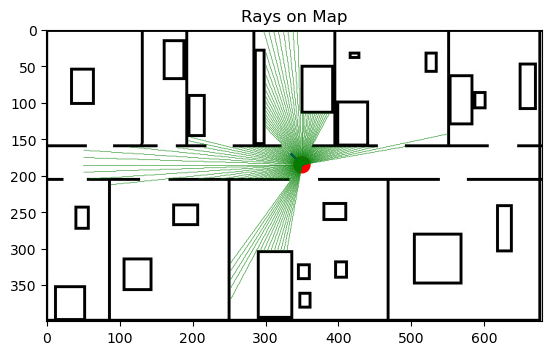

[(10, 5.7673564134705595, (19.68, 6.4)), (12, 8.174496926416941, (22.0, 5.72)), (14, 4.074702443123916, (17.96, 6.44)), (16, 3.6208286344426748, (17.48, 6.4)), (18, 3.200249990235137, (17.04, 6.4)), (20, 2.897999309868792, (16.72, 6.4)), (22, 2.6369679558159227, (16.44, 6.4)), (24, 2.4530796970339157, (16.240000000000002, 6.4)), (26, 2.2719154913860673, (16.04, 6.4)), (28, 2.129413064672987, (15.88, 6.4)), (30, 1.9895728184713426, (15.72, 6.4)), (32, 1.8867962264113205, (15.6, 6.4)), (34, 1.7861690849412888, (15.48, 6.4)), (36, 1.688075827680735, (15.36, 6.4)), (38, 1.6243152403397572, (15.280000000000001, 6.4)), (40, 1.5620499351813317, (15.200000000000001, 6.4)), (42, 1.5014659503298775, (15.120000000000001, 6.4)), (44, 1.4427751037497152, (15.040000000000001, 6.4)), (46, 1.386217876093077, (14.96, 6.4)), (48, 1.3588230201170421, (14.92, 6.4)), (50, 1.3059862173851606, (14.84, 6.4)), (52, 1.2560254774486064, (14.76, 6.4)), (54, 1.2322337440599496, (14.72, 6.4)), (56, 1.20929731662647

In [78]:
# The ropot pose is at x=14 m , y=7.4 m and theta=135
# x=350 pixel y=185 pixel
req_1('Map.jpg', x=14, y=7.4, theta=135)


In [79]:
# Requirement 2
def req_2(path,observations):
    map=preprocess(path)
    height, width = map.shape
    likelihood_map = np.zeros((height, width))
    # (liklihood,x,y,theta)
    best_pose=(-np.inf,0,0,0) 
    # Iterate through every pixel (x, y) in the grid
    for x in range(0, width,5):  
        for y in range(0, height,5):
            best_likelihood = -np.inf
            best_orientation = None
            # Loop through all orientations (θ) for each (x, y)
            for theta in range(0, 360, 5):  # Loop over orientations
                likelihood = 1
                # For each angle in the range, cast a ray and calculate the likelihood
                angles = list(range(theta - (angle_range // 2), theta + (angle_range // 2) + 1, angle_step))
                for i,angle in enumerate(angles):
                    angle_rad = np.radians(angle)
                    # Trace the ray and find the endpoint
                    x_end = int(x + (observations[i] / pixel_scale) * np.cos(angle_rad))
                    y_end = int(y - (observations[i] / pixel_scale) * np.sin(angle_rad))
                    # Check if x_end and y_end are in map boundries 
                    if 0 <= x_end < width and 0 <= y_end < height:
                        likelihood *= map[y_end, x_end]
                    else:
                    # Multiply likelihood by a very small value if out of bounds
                        likelihood *= 1e-6
                        
                if likelihood>best_likelihood:
                    best_likelihood=likelihood
                    best_orientation=theta

            likelihood_map[y,x]=best_likelihood

            if(best_likelihood>best_pose[0]):
                best_pose=(best_likelihood,x,y,best_orientation)

    plt.imshow(likelihood_map, cmap='gray')
    plt.title("Liklihood")
    plt.show()

    # Apply dilation
    structuring_element = square(5)
    dilated_map = dilation(likelihood_map, structuring_element)
    # Display the dilated image
    plt.imshow(dilated_map, cmap='gray')
    plt.title("Dilated Likelihood")
    plt.show()

    # Draw the most likely pose on the map
    original_map=io.imread(path)
    plt.imshow(original_map, cmap='gray')
    plt.title("Estimated Pose")
    draw_robot(best_pose[1],best_pose[2],best_pose[3])
    plt.show()

    
    print("Pose.x(meters)=",best_pose[1]*pixel_scale)
    print("Pose.y(meters)=",best_pose[2]*pixel_scale)
    print("Pose.theta(degree)=",best_pose[3])





    
                


                    
                    

    

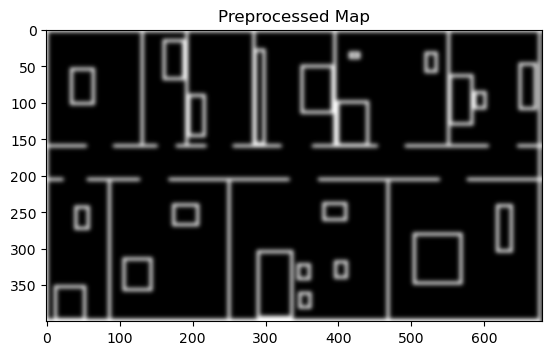

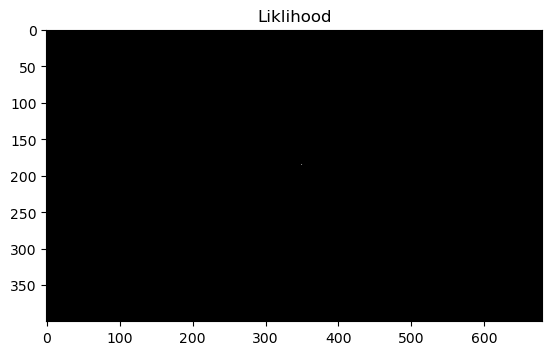

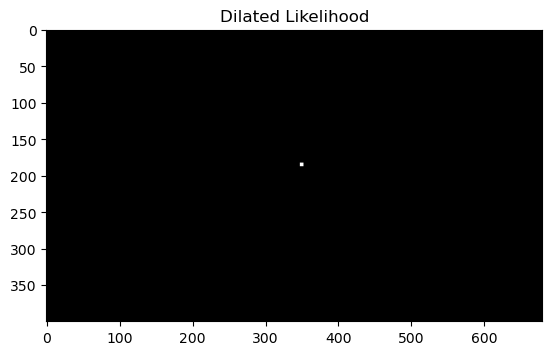

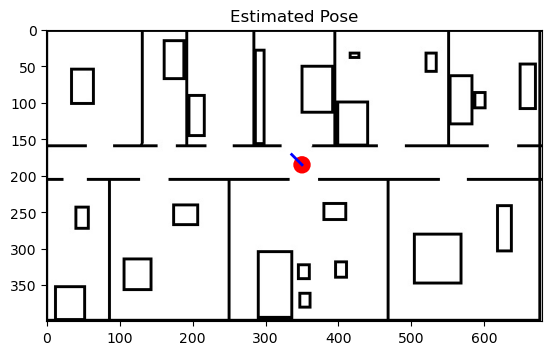

Pose.x(meters)= 14.0
Pose.y(meters)= 7.4
Pose.theta(degree)= 135


In [80]:
observations= [item[1] for item in rays_data]
req_2('Map.jpg',observations)